In [1]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils import merge_artfiles

# Load and merge ground truth and NEP data

In [2]:
# Load data containing NEP (predictions)
foldername = get_foldername('sq_pp_ner')
arts_train = load_data('train.json',foldername)
arts_dev = load_data('dev.json',foldername)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [3]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername) + load_data('dev.json',foldername)
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [4]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))

Matching titles: 477 
Total articles 477


In [5]:
# Merge ground truth blanks with original data to get full dataset
from utils_SQuAD import merge_arts_paragraph_fields
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [6]:
# Pull out sample paragraph
p = arts[1]['paragraphs'][0]

## AllenNLP Words

In [7]:
from utils_NLP import words2text
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

164
164
Frédéric François Chopin ( /ˈʃoʊpæn/; French pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ]; 22 February or 1 March 1810 – 17 October 1849 ), born Fryderyk Franciszek Chopin,[n 1 ] was a Polish and French ( by citizenship and birth of father ) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose " poetic genius was based on a professional technique that was without equal in his generation. " Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.
858


## Context

In [8]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


164
Frédéric François Chopin ( /ˈʃoʊpæn/; French pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ]; 22 February or 1 March 1810 – 17 October 1849 ), born Fryderyk Franciszek Chopin,[n 1 ] was a Polish and French ( by citizenship and birth of father ) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose " poetic genius was based on a professional technique that was without equal in his generation. " Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.
858


## Context_blanked

In [9]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

164
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification'])
Frédéric François Chopin ( /ˈʃoʊpæn/ ; ______ pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ] ; 22 February or 1 March ______ – 17 October ______ ) , born Fryderyk Franciszek Chopin,[n 1 ] was a ______ and ______ ( by citizenship and birth of father ) composer and a virtuoso pianist of the ______ ______ , who wrote primarily for the ______ ______ . He gained and has maintained renown worldwide as one of the leading musicians of his ______ , whose " poetic genius was based on a professional technique that was without equal in his generation . " Chopin was born in what was then the ______ of ______ , and grew up in ______ , which after 1815 became part of Congress Poland . A child prodigy , he completed his musical education and composed his earlier works in ______ before leaving Poland at the age of ______ , less than a month before the outbreak of the November 1830 Uprising .


In [10]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

French
1810
1849
Polish
French
Romantic
era
solo
piano
era
Duchy
Warsaw
Warsaw
Warsaw
20


# Single paragraph - Compare blanks

## First, just look at the raw text

## Now do statistics - TPR, FPR, etc

In [11]:
# Pull out sample paragraph
p = arts[0]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
tags = [not t == 'O' for t in tags]   # Convert to binary


In [12]:
# Ground truth
blank_classification = p['blank_classification']
blank_classification = [b == 1 for b in blank_classification] # Convert to binary

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 149. Length ground truth blanks: 149


In [13]:
# Side by side compare
context_blanked = p['context_blanked']
context_blanked_split = context_blanked.strip().split()
words_blanked = [words[i] if not t else '______' for i,t in enumerate(tags)]

N=len(words_blanked)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(context_blanked_split[:N],words_blanked[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
Beyoncé				______
Giselle				______
______				______
-				-
Carter				______
(				(
/biːˈjɒnseɪ/				/biːˈjɒnseɪ/
bee				bee
-				-
YON				______
-				-
say				say
)				)
(				(
born				born
September				September
4				4
,				,
1981				1981
)				)


In [14]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [15]:
print(ACC)
print(ACC2)

0.7919463087248322
0.7919463087248322


In [16]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [17]:
print(TPR)
print(FPR)

0.4444444444444444
0.16030534351145037


In [18]:
p['context']

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [19]:
from utils_NLP import text2sentences
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=4
Nsentences_from_words=4


In [20]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

2.0
5.25


# Single article - compare blanks

In [21]:
# Pull out sample paragraph
a = arts[0]

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
tags = [not t == 'O' for t in tags]   # Convert to binary

In [22]:
# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
blank_classification = [b == 1 for b in blank_classification] # Convert to binary

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 11058. Length ground truth blanks: 11058


In [23]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [24]:
print(ACC)
print(ACC2)

0.7944474588533189
0.7944474588533189


In [25]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [26]:
print(TPR)
print(FPR)

0.5308176100628931
0.18513105329825588


In [27]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=378


In [28]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

1.1164021164021165
5.026455026455026


# All articles - compare blanks

In [29]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
TPpersent0 = []
FPpersent0 = []
bads = []

i=0
for a in arts:
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
    tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
    tags = [not t == 'O' for t in tags]   # Convert to binary

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))
    
    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))
        
        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        TPR = 0.5
        FPR = 0.5
        ACC = 0.5
        TP = 100
        FP = 100
        TPpersent = 1
        FPpersent = 1
        bads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        
        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2
    
    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    i=i+1



Warning article 175 contains 0 ground truth blanks and 274 tags. Likely bad
Warning article 440 contains 0 ground truth blanks and 116 tags. Likely bad
Warning article 441 contains 0 ground truth blanks and 78 tags. Likely bad


In [30]:

# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Plot TPR

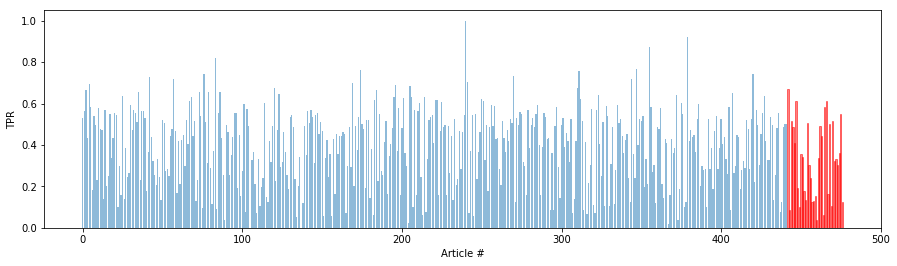

In [31]:


figure(num=None, figsize=(15, 4),facecolor='w', edgecolor='k')
barlist = plt.bar(range(len(TPR0)), TPR0, align='center', alpha=0.5)
plt.xlabel('Article #')
plt.ylabel('TPR')
for i in range(Ntrain,Ntrain+Ndev):
    barlist[i].set_color('r')
plt.show()

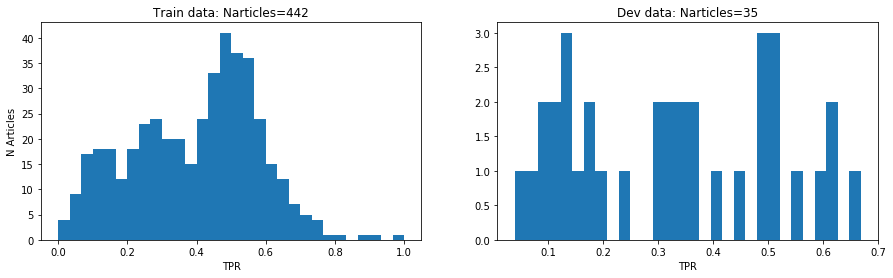

In [32]:
# figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
ax1.hist(TPR0[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
ax1.set_title("Train data: Narticles=" + str(Ntrain));
ax1.set_ylabel('N Articles');
ax1.set_xlabel('TPR');

ax2.hist(TPR0[Ntrain:], bins=30);  # arguments are passed to np.histogram
ax2.set_title("Dev data: Narticles=" + str(Ndev));
ax2.set_xlabel('TPR');

## Plot FPR

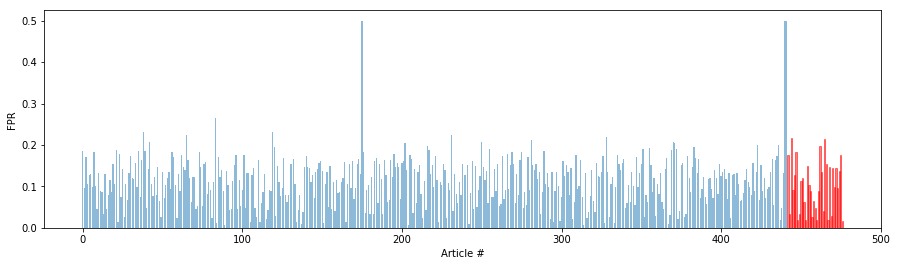

In [33]:


figure(num=None, figsize=(15, 4),facecolor='w', edgecolor='k')
barlist = plt.bar(range(len(FPR0)), FPR0, align='center', alpha=0.5)
plt.xlabel('Article #')
plt.ylabel('FPR')
for i in range(Ntrain,Ntrain+Ndev):
    barlist[i].set_color('r')
plt.show()

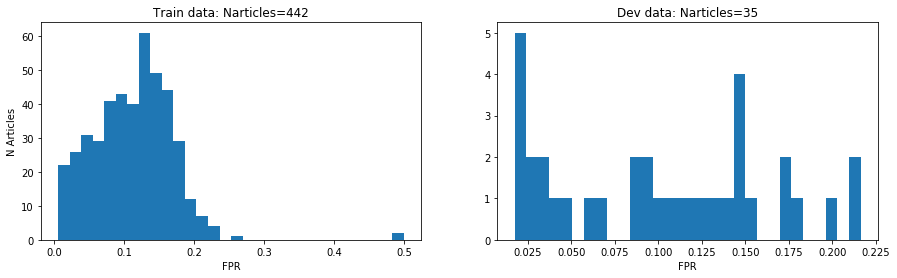

In [34]:
# figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
ax1.hist(FPR0[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
ax1.set_title("Train data: Narticles=" + str(Ntrain));
ax1.set_ylabel('N Articles');
ax1.set_xlabel('FPR');

ax2.hist(FPR0[Ntrain:], bins=30);  # arguments are passed to np.histogram
ax2.set_title("Dev data: Narticles=" + str(Ndev));
ax2.set_xlabel('FPR');

## Plot True positives per sentence

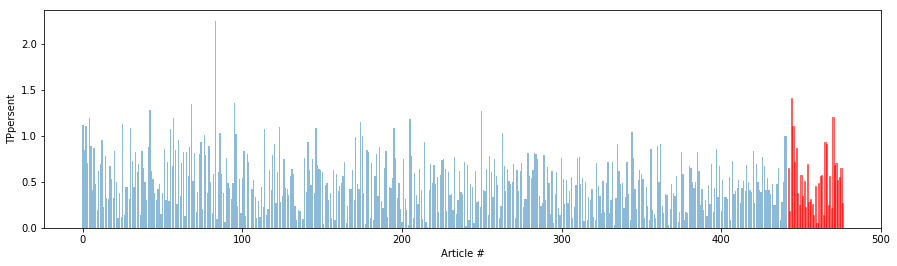

In [35]:
figure(num=None, figsize=(15, 4),facecolor='w', edgecolor='k')
barlist = plt.bar(range(len(TPpersent0)), TPpersent0, align='center', alpha=0.5)
plt.xlabel('Article #')
plt.ylabel('TPpersent')
for i in range(Ntrain,Ntrain+Ndev):
    barlist[i].set_color('r')
plt.show()

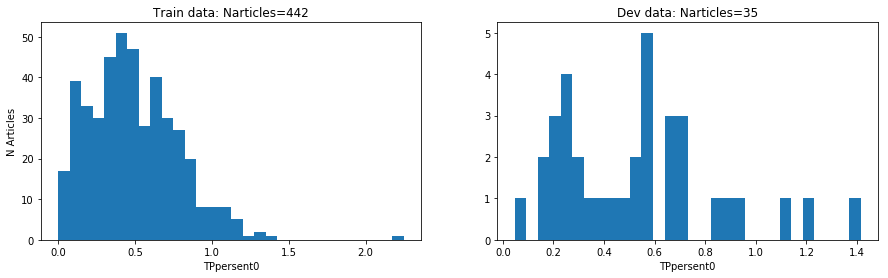

In [36]:
# figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
ax1.hist(TPpersent0[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
ax1.set_title("Train data: Narticles=" + str(Ntrain));
ax1.set_ylabel('N Articles');
ax1.set_xlabel('TPpersent0');

ax2.hist(TPpersent0[Ntrain:], bins=30);  # arguments are passed to np.histogram
ax2.set_title("Dev data: Narticles=" + str(Ndev));
ax2.set_xlabel('TPpersent0');

## Plot False positives per sentence

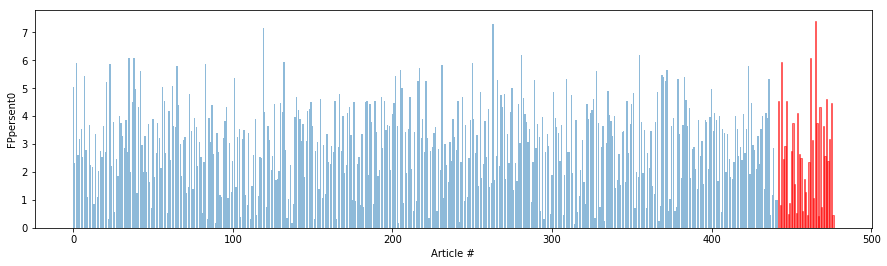

In [37]:
figure(num=None, figsize=(15, 4),facecolor='w', edgecolor='k')
barlist = plt.bar(range(len(FPpersent0)), FPpersent0, align='center', alpha=0.5)
plt.xlabel('Article #')
plt.ylabel('FPpersent0')
for i in range(Ntrain,Ntrain+Ndev):
    barlist[i].set_color('r')
plt.show()

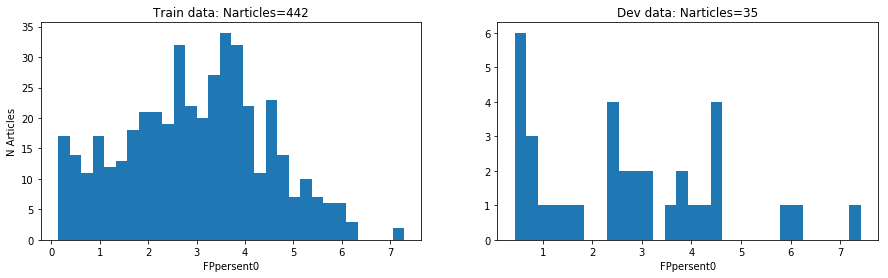

In [38]:
# figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
ax1.hist(FPpersent0[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
ax1.set_title("Train data: Narticles=" + str(Ntrain));
ax1.set_ylabel('N Articles');
ax1.set_xlabel('FPpersent0');

ax2.hist(FPpersent0[Ntrain:], bins=30);  # arguments are passed to np.histogram
ax2.set_title("Dev data: Narticles=" + str(Ndev));
ax2.set_xlabel('FPpersent0');